<a href="https://colab.research.google.com/github/eolson615/SpringboardDSCareerTrack/blob/master/Capstone2_LogReg_and_RFC_usingselectedfeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In this notebook, I take the feature selection information I gathered from the EDA notebook (see Capstone2_EDA) and see if using it will help any of the models tested in earlier notebooks (see Capstone2_LogisticRegression_imbalanceddata and Capstone2_randomforest notebooks for earlier models). This will include combining the "no" and "no internet service" categories for the features that contain these categories except for the feature 'InternetService' to help account for possible issues of collinearity (as noticed in Capstone2_EDA notebook). I will also drop 'gender' and 'PhoneService', per the chi-squared test (conducted in the Capstone2_featureselection notebook).<br><br> So far the best result I have obtained has been using a LogisticRegression model using a SMOTE method to help with the imbalanced data. This model returned a 0.79 recall for Yes with an overall accuracy of 0.75. These are the metrics I am looking to improve. <br><br> In this notebook I use both a LogisticRegression model (named logreg and additional information in the name to designate any modifications) and the RandomForestClassifier model (named rfc and additional information in the name to designate any modifications).<br><br> In preparing the data I have chosen not to use a pipeline. This allows me to use LogisticRegression.coef_ and RandomForestClassifier.feature_importance_. Then I run the LogisticRegression models (a model not adjusted for imbalanced data, a SMOTE model, and a nearmiss model) followed by the RandomForestClassifier models (a model not adjusted for imbalanced data, a SMOTE adjusted model, and a nearmiss adjusted model). In conclusion is a comparison of all of the models and their ROC curves and AUC scores.

In [1]:
import warnings  #This was added for aesthetics on GitHub and was not implemented during the composition of this notebook
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imb_pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_url = 'https://raw.githubusercontent.com/eolson615/SpringboardDSCareerTrack/master/Capstone2/Data/telcodata_posteda.csv'
df = pd.read_csv(df_url, index_col=[0])
df.head(20)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


##Here I split the data into X and y. During this process I drop the features 'gender' and 'PhoneService'.

In [3]:
X = df.drop(columns=['Churn', 'gender', 'PhoneService'])
y = pd.Series(df.Churn.map(dict(Yes=1, No=0)))
print(X.shape, y.shape)

(7043, 17) (7043,)


##Below, I convert a 'No' and 'No internet service' entry into a 0 while making a 'Yes' entry into a 1. This creates dummy variables for these categories. I then create dummy variables for the other categorical features.

In [4]:
internet_features_conversion_list = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in internet_features_conversion_list:
  X[i] = X[i].map({'Yes':1, 'No':0, 'No internet service':0})
X.head(20)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Yes,No,1,No phone service,DSL,0,1,0,0,0,0,Month-to-month,Yes,Electronic check,29.85,29.85
1,0,No,No,34,No,DSL,1,0,1,0,0,0,One year,No,Mailed check,56.95,1889.50
2,0,No,No,2,No,DSL,1,1,0,0,0,0,Month-to-month,Yes,Mailed check,53.85,108.15
3,0,No,No,45,No phone service,DSL,1,0,1,1,0,0,One year,No,Bank transfer (automatic),42.30,1840.75
4,0,No,No,2,No,Fiber optic,0,0,0,0,0,0,Month-to-month,Yes,Electronic check,70.70,151.65
5,0,No,No,8,Yes,Fiber optic,0,0,1,0,1,1,Month-to-month,Yes,Electronic check,99.65,820.50
6,0,No,Yes,22,Yes,Fiber optic,0,1,0,0,1,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.40
7,0,No,No,10,No phone service,DSL,1,0,0,0,0,0,Month-to-month,No,Mailed check,29.75,301.90
8,0,Yes,No,28,Yes,Fiber optic,0,0,1,1,1,1,Month-to-month,Yes,Electronic check,104.80,3046.05
9,0,No,Yes,62,No,DSL,1,1,0,0,0,0,One year,No,Bank transfer (automatic),56.15,3487.95


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   MultipleLines     7043 non-null   object 
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   int64  
 7   OnlineBackup      7043 non-null   int64  
 8   DeviceProtection  7043 non-null   int64  
 9   TechSupport       7043 non-null   int64  
 10  StreamingTV       7043 non-null   int64  
 11  StreamingMovies   7043 non-null   int64  
 12  Contract          7043 non-null   object 
 13  PaperlessBilling  7043 non-null   object 
 14  PaymentMethod     7043 non-null   object 
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   float64


In [6]:
dummy_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=dummy_columns, drop_first=True)
X.head()

,SeniorCitizen,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,0,0,29.85,29.85,1,0,1,0,0,0,0,0,1,0,1,0
1,0,34,1,0,1,0,0,0,56.95,1889.50,0,0,0,0,0,0,1,0,0,0,0,1
2,0,2,1,1,0,0,0,0,53.85,108.15,0,0,0,0,0,0,0,0,1,0,0,1
3,0,45,1,0,1,1,0,0,42.30,1840.75,0,0,1,0,0,0,1,0,0,0,0,0
4,0,2,0,0,0,0,0,0,70.70,151.65,0,0,0,0,1,0,0,0,1,0,1,0


##Now, I will perform my train test split on the data followed by standardizing the numeric features in the Xtrain and Xtest data sets using StandardScaler.

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=56, stratify=y)
print('Xtrain', type(Xtrain), Xtrain.shape, Xtrain)
print('\n')
print("Xtest", type(Xtest), Xtest.shape, Xtest)
print('\n')
print('ytrain', type(ytrain), ytrain.shape, ytrain)
print('\n')
print("ytest", type(ytest), ytest.shape, ytest)

Xtrain <class 'pandas.core.frame.DataFrame'> (5282, 22)       SeniorCitizen  ...  PaymentMethod_Mailed check
3333              0  ...                           0
1526              0  ...                           0
3336              0  ...                           1
6451              1  ...                           0
2192              1  ...                           0
...             ...  ...                         ...
5604              0  ...                           0
4739              0  ...                           0
523               0  ...                           0
2471              0  ...                           0
3115              0  ...                           0

[5282 rows x 22 columns]


Xtest <class 'pandas.core.frame.DataFrame'> (1761, 22)       SeniorCitizen  ...  PaymentMethod_Mailed check
5480              0  ...                           1
4274              0  ...                           0
5587              1  ...                           0
36           

In [8]:
Xtrain[['tenure','MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(Xtrain[['tenure','MonthlyCharges', 'TotalCharges']].to_numpy())
Xtrain.head()

,SeniorCitizen,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3333,0,-0.824915,0,0,0,0,0,0,-1.503483,-0.908625,0,1,0,0,0,1,0,1,0,0,0,0
1526,0,-1.190930,0,1,0,0,1,1,1.033000,-0.872833,0,0,0,0,1,0,0,0,0,0,1,0
3336,0,0.923822,0,0,0,0,0,0,-1.471798,-0.524923,1,1,0,0,0,1,0,1,0,0,0,1
6451,1,1.371173,1,1,1,1,1,1,1.728407,2.477935,1,1,0,1,1,0,1,0,1,0,1,0
2192,1,0.964490,1,1,1,1,1,1,0.707810,1.133130,1,0,0,0,0,0,0,1,1,0,0,0


In [9]:
Xtest[['tenure','MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(Xtest[['tenure','MonthlyCharges', 'TotalCharges']].to_numpy())
Xtest.head()

,SeniorCitizen,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5480,0,-1.293168,0,0,0,0,0,0,-0.670249,-0.995660,0,0,0,0,0,0,0,0,1,0,0,1
4274,0,0.505590,0,0,0,0,0,0,-1.544178,-0.636602,0,0,0,0,0,1,1,0,0,0,0,0
5587,1,0.546471,0,1,1,0,1,0,0.840610,0.787158,0,0,0,0,1,0,1,0,1,0,0,0
36,0,-1.129644,0,0,0,0,0,0,0.129618,-0.877051,0,0,0,0,1,0,0,0,1,0,1,0
2316,0,-1.170525,0,0,0,0,0,0,-1.483283,-0.983580,0,0,0,0,0,1,0,0,0,0,0,1


#Now, I train and test the LogisticRegression models (a nonadjusted, a SMOTE, and a nearmiss). I use classification_report to check how well the models performed and .coef_ to analyze how the models used each feature.

In [10]:
logreg_notadjusted = LogisticRegression(max_iter=5000)
logreg_notadjusted.fit(Xtrain, ytrain)
ypred_train_notadjusted = logreg_notadjusted.predict(Xtrain)
class_report_train_notadjusted = classification_report(ytrain, ypred_train_notadjusted)
ypred_test_notadjusted = logreg_notadjusted.predict(Xtest)
class_report_test_notadjusted = classification_report(ytest, ypred_test_notadjusted)
print('Classification report on ypred_train_notadjusted')
print(class_report_train_notadjusted)
print('Classification report on ypred_test_notadjusted')
print(class_report_test_notadjusted)

Classification report on ypred_train_notadjusted
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3880
           1       0.67      0.57      0.61      1402

    accuracy                           0.81      5282
   macro avg       0.76      0.73      0.74      5282
weighted avg       0.80      0.81      0.80      5282

Classification report on ypred_test_notadjusted
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1294
           1       0.63      0.57      0.60       467

    accuracy                           0.80      1761
   macro avg       0.74      0.72      0.73      1761
weighted avg       0.79      0.80      0.79      1761



In [11]:
df_X_column = pd.melt(pd.DataFrame(data=Xtrain.columns)).drop(columns='variable')
logreg_notadjusted_coef = pd.melt(pd.DataFrame(data=logreg_notadjusted.coef_)).drop(columns='variable')
logreg_notadjusted_coef_withnames = logreg_notadjusted_coef.join(df_X_column, how='outer', rsuffix='feature').sort_values(by=['value'], ignore_index=True)
logreg_notadjusted_coef_withnames

,value,valuefeature
0,-1.432650,tenure
1,-1.429444,Contract_Two year
2,-0.810374,Contract_One year
3,-0.537648,InternetService_No
4,-0.502888,TechSupport
5,-0.380000,OnlineSecurity
6,-0.235939,OnlineBackup
7,-0.143117,Dependents_Yes
8,-0.116041,PaymentMethod_Credit card (automatic)
9,-0.070927,PaymentMethod_Mailed check


In [12]:
logreg_smote = LogisticRegression(max_iter=5000)
smote = SMOTE(random_state=56)
smote_pipeline = imb_pipeline(smote, logreg_smote)
smote_pipeline.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=56, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [13]:
ypred_train_smote = logreg_smote.predict(Xtrain)
class_report_train_smote = classification_report(ytrain, ypred_train_smote)
ypred_test_smote = logreg_smote.predict(Xtest)
class_report_test_smote = classification_report(ytest, ypred_test_smote)
print('Classification report on ypred_train_smote')
print(class_report_train_smote)
print('Classification report on ypred_test_smote')
print(class_report_test_smote)

Classification report on ypred_train_smote
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      3880
           1       0.53      0.81      0.64      1402

    accuracy                           0.76      5282
   macro avg       0.72      0.77      0.73      5282
weighted avg       0.81      0.76      0.77      5282

Classification report on ypred_test_smote
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1294
           1       0.51      0.79      0.62       467

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.80      0.75      0.76      1761



In [14]:
logreg_smote_coef = pd.melt(pd.DataFrame(data=logreg_smote.coef_)).drop(columns='variable')
logreg_smote_coef_withnames = logreg_smote_coef.join(df_X_column, how='outer', rsuffix='feature').sort_values(by=['value'], ignore_index=True)
logreg_smote_coef_withnames

,value,valuefeature
0,-1.559952,Contract_Two year
1,-1.520070,tenure
2,-0.915902,Contract_One year
3,-0.636051,TechSupport
4,-0.597119,OnlineSecurity
5,-0.475362,InternetService_No
6,-0.217236,OnlineBackup
7,-0.203442,PaymentMethod_Credit card (automatic)
8,-0.198221,Dependents_Yes
9,-0.117712,DeviceProtection


In [15]:
logreg_nearmiss = LogisticRegression(max_iter=5000)
nearmiss = NearMiss(random_state=56)
nearmiss_pipeline = imb_pipeline(nearmiss, logreg_nearmiss)
nearmiss_pipeline.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('nearmiss',
                 NearMiss(n_jobs=1, n_neighbors=3, n_neighbors_ver3=3,
                          random_state=56, ratio=None, return_indices=False,
                          sampling_strategy='auto', version=1)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [16]:
ypred_train_nearmiss = nearmiss_pipeline.predict(Xtrain)
class_report_train_nearmiss = classification_report(ytrain, ypred_train_nearmiss)
ypred_test_nearmiss = nearmiss_pipeline.predict(Xtest)
class_report_test_nearmiss = classification_report(ytest, ypred_test_nearmiss)
print('Classification report on ypred_train_nearmiss')
print(class_report_train_nearmiss)
print('Classification report on ypred_test_nearmiss')
print(class_report_test_nearmiss)

Classification report on ypred_train_nearmiss
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      3880
           1       0.43      0.78      0.56      1402

    accuracy                           0.67      5282
   macro avg       0.66      0.71      0.65      5282
weighted avg       0.77      0.67      0.69      5282

Classification report on ypred_test_nearmiss
              precision    recall  f1-score   support

           0       0.89      0.62      0.73      1294
           1       0.43      0.79      0.56       467

    accuracy                           0.66      1761
   macro avg       0.66      0.70      0.64      1761
weighted avg       0.77      0.66      0.68      1761



#Here, I train and test the RandomForestClassifier models (a nonadjusted, a SMOTE, and a nearmiss). Again, I use classification_report to check how well the models performed but instead use feature_importance_ to analyze how the models used each feature.

In [17]:
rfc_notadjusted = RandomForestClassifier(n_estimators=500, random_state=56)
rfc_notadjusted.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=56, verbose=0,
                       warm_start=False)

In [18]:
ypred_test_rfc_notadjusted = rfc_notadjusted.predict(Xtest)
class_report_test_rfc_notadjusted = classification_report(ytest, ypred_test_rfc_notadjusted)
print(class_report_test_rfc_notadjusted)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1294
           1       0.64      0.49      0.56       467

    accuracy                           0.79      1761
   macro avg       0.74      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761



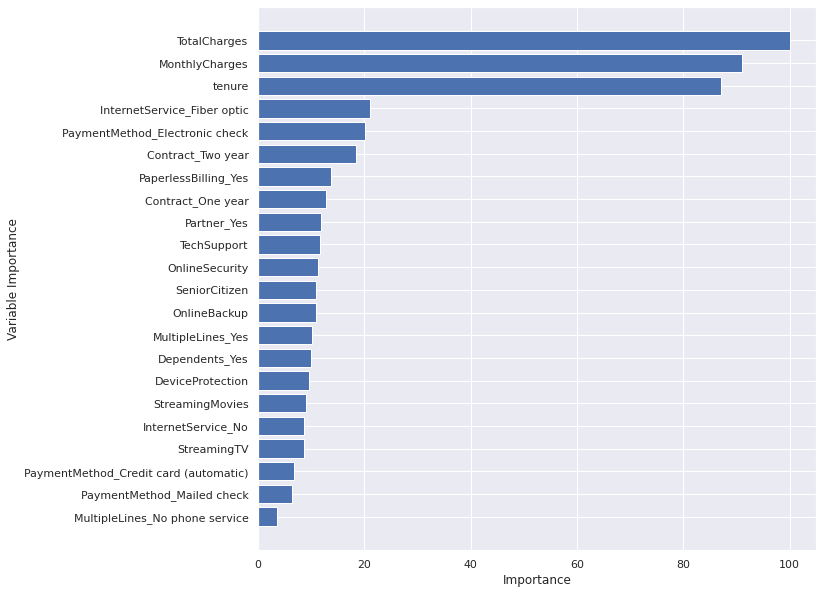

In [19]:
feature_importance = rfc_notadjusted.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtest.columns[sorted_idx], )
plt.xlabel("Importance")
plt.ylabel('Variable Importance')
plt.show()

In [20]:
rfc_smote = RandomForestClassifier(n_estimators=300, random_state = 56)
smote = SMOTE(random_state = 56)
rfc_smote_pipeline = imb_pipeline(smote, rfc_smote)
rfc_smote_pipeline.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=56, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators

In [21]:
ypred_test_rfc_smote = rfc_smote_pipeline.predict(Xtest)
class_report_test_rfc_smote = classification_report(ytest, ypred_test_rfc_smote)
print(class_report_test_rfc_smote)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1294
           1       0.59      0.58      0.59       467

    accuracy                           0.78      1761
   macro avg       0.72      0.72      0.72      1761
weighted avg       0.78      0.78      0.78      1761



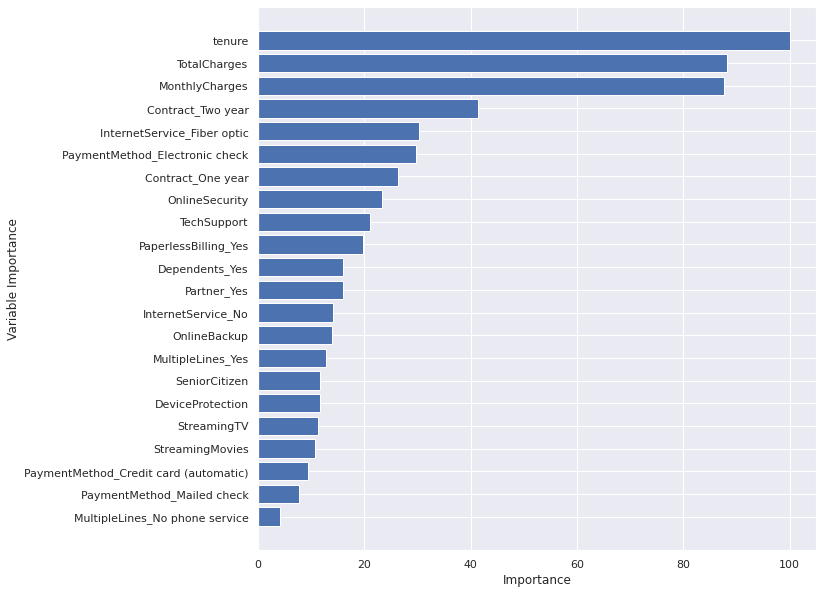

In [22]:
feature_importance = rfc_smote.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtest.columns[sorted_idx], )
plt.xlabel("Importance")
plt.ylabel('Variable Importance')
plt.show()

In [23]:
rfc_nearmiss = RandomForestClassifier(n_estimators=300, random_state=56)
nearmiss = NearMiss(random_state = 56)
rfc_nearmiss_pipeline = imb_pipeline(nearmiss, rfc_nearmiss)
rfc_nearmiss_pipeline.fit(Xtrain, ytrain)
ypred_test_rfc_nearmiss = rfc_nearmiss_pipeline.predict(Xtest)
class_report_test_rfc_nearmiss = classification_report(ytest, ypred_test_rfc_nearmiss)
print(class_report_test_rfc_nearmiss)

              precision    recall  f1-score   support

           0       0.82      0.44      0.57      1294
           1       0.32      0.73      0.44       467

    accuracy                           0.52      1761
   macro avg       0.57      0.58      0.51      1761
weighted avg       0.68      0.52      0.54      1761



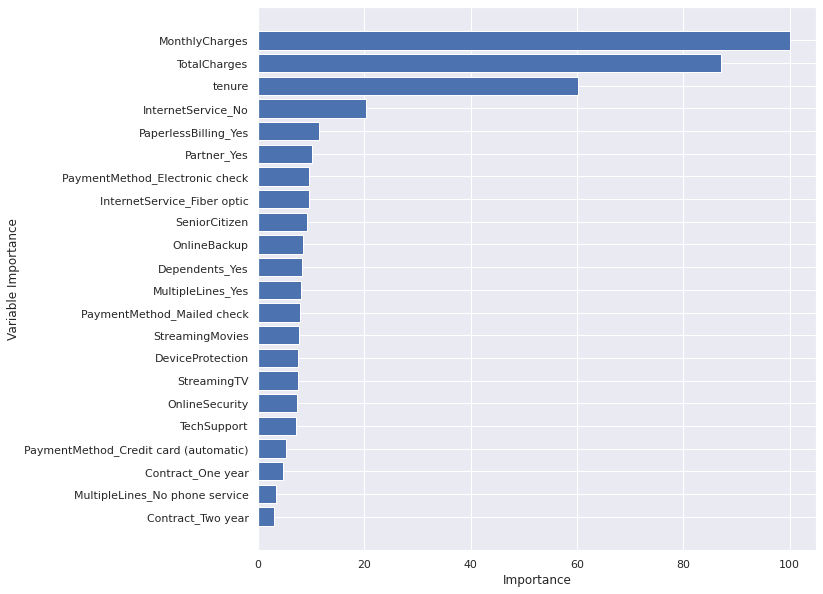

In [24]:
feature_importance = rfc_nearmiss.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtest.columns[sorted_idx], )
plt.xlabel("Importance")
plt.ylabel('Variable Importance')
plt.show()

##I train and test a SMOTE adjusted LogisticRegression model with a data set that has the features with possible collinearity issues dropped.

In [25]:
X_selected = df.drop(columns=['Churn', 'gender','OnlineSecurity', 
                              'OnlineBackup', 'DeviceProtection', 'TechSupport',
                              'StreamingTV', 'StreamingMovies'])
print(X_selected.shape)

(7043, 12)


In [26]:
dummy_columns = X_selected.select_dtypes(include=['object']).columns
X_selected = pd.get_dummies(X_selected, columns=dummy_columns, drop_first=True)
X_selected.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,1,0,0,1,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,0,1,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,0,1,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,0,0,1,0,0,1,0,0,0,1,0,1,0


In [27]:
Xtrain_selected, Xtest_selected, ytrain, ytest = train_test_split(X_selected, y, random_state=56, stratify=y)
print('Xtrain', type(Xtrain), Xtrain.shape, Xtrain)
print('\n')
print("Xtest", type(Xtest), Xtest.shape, Xtest)
print('\n')
print('ytrain', type(ytrain), ytrain.shape, ytrain)
print('\n')
print("ytest", type(ytest), ytest.shape, ytest)

Xtrain <class 'pandas.core.frame.DataFrame'> (5282, 22)       SeniorCitizen  ...  PaymentMethod_Mailed check
3333              0  ...                           0
1526              0  ...                           0
3336              0  ...                           1
6451              1  ...                           0
2192              1  ...                           0
...             ...  ...                         ...
5604              0  ...                           0
4739              0  ...                           0
523               0  ...                           0
2471              0  ...                           0
3115              0  ...                           0

[5282 rows x 22 columns]


Xtest <class 'pandas.core.frame.DataFrame'> (1761, 22)       SeniorCitizen  ...  PaymentMethod_Mailed check
5480              0  ...                           1
4274              0  ...                           0
5587              1  ...                           0
36           

In [28]:
Xtrain_selected[['tenure','MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(Xtrain_selected[['tenure','MonthlyCharges', 'TotalCharges']].to_numpy())
Xtrain_selected.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3333,0,-0.824915,-1.503483,-0.908625,0,1,1,0,0,0,1,0,1,0,0,0,0
1526,0,-1.190930,1.033000,-0.872833,0,0,1,0,0,1,0,0,0,0,0,1,0
3336,0,0.923822,-1.471798,-0.524923,1,1,1,0,0,0,1,0,1,0,0,0,1
6451,1,1.371173,1.728407,2.477935,1,1,1,0,1,1,0,1,0,1,0,1,0
2192,1,0.964490,0.707810,1.133130,1,0,1,0,0,0,0,0,1,1,0,0,0


In [29]:
Xtest_selected[['tenure','MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(Xtest_selected[['tenure','MonthlyCharges', 'TotalCharges']].to_numpy())
Xtest_selected.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5480,0,-1.293168,-0.670249,-0.995660,0,0,1,0,0,0,0,0,0,1,0,0,1
4274,0,0.505590,-1.544178,-0.636602,0,0,1,0,0,0,1,1,0,0,0,0,0
5587,1,0.546471,0.840610,0.787158,0,0,1,0,0,1,0,1,0,1,0,0,0
36,0,-1.129644,0.129618,-0.877051,0,0,1,0,0,1,0,0,0,1,0,1,0
2316,0,-1.170525,-1.483283,-0.983580,0,0,1,0,0,0,1,0,0,0,0,0,1


In [30]:
logreg_smote_selected = LogisticRegression(max_iter=5000)
smote_pipeline_selected = imb_pipeline(smote, logreg_smote_selected)
smote_pipeline_selected.fit(Xtrain_selected, ytrain)
ypred_train_smote_selected = logreg_smote_selected.predict(Xtrain_selected)
class_report_train_smote_selected = classification_report(ytrain, ypred_train_smote_selected)
ypred_test_smote_selected = logreg_smote_selected.predict(Xtest_selected)
class_report_test_smote_selected = classification_report(ytest, ypred_test_smote_selected)
print('Classification report on ypred_train_smote_selected')
print(class_report_train_smote_selected)
print('Classification report on ypred_test_smote_selected')
print(class_report_test_smote_selected)

Classification report on ypred_train_smote_selected
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      3880
           1       0.51      0.81      0.63      1402

    accuracy                           0.75      5282
   macro avg       0.71      0.77      0.72      5282
weighted avg       0.81      0.75      0.76      5282

Classification report on ypred_test_smote_selected
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1294
           1       0.49      0.79      0.60       467

    accuracy                           0.72      1761
   macro avg       0.70      0.75      0.70      1761
weighted avg       0.79      0.72      0.74      1761



##Below is compiled a list of the recall scores along with the accuracy scores. In the subsequent plot, we can see that the logistic regression model that was adjusted using the SMOTE method returned the highest recall value along with the highest overall accuracy. This is the same as in the previous notebooks.<br><br> Adjusting the features and dropping features to help simplify the model did not produce any added benefit in terms of recall or accuracy.

In [31]:
listof_model_test = ['chi_featureselected_logreg_notadjusted', 'chi_featureselected_logreg_smote', 'chi_featureselected_logreg_nearmiss', 'chi_featureselected_rfc_notadjusted', 'chi_featureselected_rfc_smote', 'chi_featureselected_rfc_nearmiss', 'col_featureselected_logreg_smote']
listof_ypred_test = [ypred_test_notadjusted, ypred_test_smote, ypred_test_nearmiss, ypred_test_rfc_notadjusted, ypred_test_rfc_smote, ypred_test_rfc_nearmiss, ypred_test_smote_selected ]
dict_for_pred_scores = {}
list_recall_scores = []
list_accuracy_scores = []

for ypred in listof_ypred_test:
  recallscore = recall_score(ytest, ypred)
  list_recall_scores.append(recallscore)
  accuracyscore = accuracy_score(ytest, ypred)
  list_accuracy_scores.append(accuracyscore)

dict_for_pred_scores['model'] = listof_model_test
dict_for_pred_scores['recall_score'] = list_recall_scores
dict_for_pred_scores['accuracy_score'] = list_accuracy_scores
df_model_scores = pd.DataFrame.from_dict(dict_for_pred_scores)
df_model_scores.to_csv('featureselected_model_scores.csv')
df_model_scores

,model,recall_score,accuracy_score
0,chi_featureselected_logreg_notadjusted,0.565310,0.797274
1,chi_featureselected_logreg_smote,0.790150,0.746167
2,chi_featureselected_logreg_nearmiss,0.794433,0.662692
3,chi_featureselected_rfc_notadjusted,0.492505,0.792731
4,chi_featureselected_rfc_smote,0.582441,0.781374
5,chi_featureselected_rfc_nearmiss,0.725910,0.516184
6,col_featureselected_logreg_smote,0.792291,0.724588


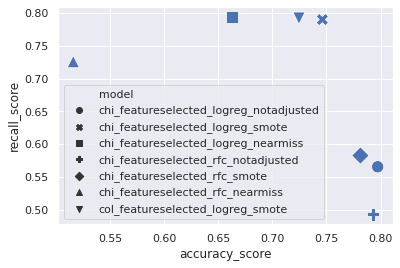

In [32]:
ax = sns.scatterplot(x="accuracy_score", y="recall_score",
                    style="model", data=df_model_scores, s=150)

In [33]:
from google.colab import files
files.download('featureselected_model_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>